# Personal functions to be called throughout the code

In [1]:
def standardize(parameter):
    """
    :param parameter: the array with the parameters you wish to standardize
    :return param_mean: mean of the input array
    :return param_std : standard deviation of the input array
    :return stdized_param: final standardized array
    """
    import numpy as np
    
    param_mean    = np.mean(parameter)
    param_std     = np.std(parameter)
    stdized_param = []                  # standardized parameter -- output
    for i in range(parameter.size):
        param_temp = (parameter[i] - param_mean)/param_std
        stdized_param.append(param_temp)
    stdized_param = np.array(stdized_param)
    return (param_mean, param_std, stdized_param)

In [2]:
def un_standardize(stdized_par, mean, std):
    """
    This function undoes what the former does!
    """
    
    import numpy as np
    
    recovered_par = []
    for i in range(stdized_par.size):
        param_temp = stdized_par[i]*std + mean
        recovered_par.append(param_temp)
    recovered_par = np.array(recovered_par)
    return (recovered_par)

# Libraries

In [3]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import pystan
import time

# Configuring the regression parameters

In [4]:
my_data = pd.read_csv('../../Catalogue/binom_reg_dataset.csv')

In [5]:
# filtering the dataset
redshifts = my_data['Z']
index     = np.where(redshifts.values<=0.4)

# parameters of interest
logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values[index].astype(int)    # y axis: logit class: UVUP yes/no
whan_class  = my_data['WHAN(0-NA;1-RP;2-wA;3-sA;4-SF)'].values[index].astype(int)  # My types of galaxies
mass        = my_data['STELLAR_MASS'].values[index].astype(int)                    # 1st parameter
redshift    = redshifts.values[index].astype(float)                                # 2nd parameter

In [6]:
# original parameters
mean_mass, std_mass, x2 = standardize(mass)
x1      = redshift
y       = logit_class
classes = (whan_class+1).astype(int)        # Must sum +1 to avoid index issues with STAN
n_obs   = x1.size
n_class = np.unique(classes).size

# new parameters - important for plotting!
n_obs2 = 20
x1_sim = np.linspace(x1.min(), x1.max(), n_obs2)
x2_sim = np.linspace(x2.min(), x2.max(), n_obs2)

# grid
plot_x1, plot_x2 = np.meshgrid(x1_sim, x2_sim)  # THIS IS WHERE THE GRID IS DONE
plot_x1 = plot_x1.reshape((n_obs2**2), 1)
plot_x2 = plot_x2.reshape((n_obs2**2), 1)

In [7]:
print x2.min(), x2.max() # sanity check
print np.median(x2)
print plot_x1.shape

-2.582215516074275 1.5690974667054223
-0.5065590246844265
(400, 1)


In [8]:
# dataset to be used in the regression
regression_data      = {}                                                 # Dictionary, as stated in the pystan manual
regression_data['Y'] = y
regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2, x2, x2**2)))
regression_data['K'] = regression_data['X'][0,:].size                     # Number of betas -- b0, b1, b2, b3, b4
regression_data['W'] = classes
regression_data['N'] = n_obs
regression_data['C'] = n_class                                      # Number of different classes (partial pooling)

# dataset to be used in the plot -- after meshgrid
regression_data['X2'] = sm.add_constant(np.column_stack((plot_x1, plot_x1**2, plot_x2, plot_x2)))
regression_data['N2'] = n_obs2**2

In [9]:
# Fit: STAN code ----------------------------------------------------------------------------------------------------------
stan_code = """
// DECLARATION OF VARIABLES -----------------------------------------------------------------------------------------------
data{
    int<lower=1> N;
    int<lower=1> N2;
    int<lower=1> K;
    int<lower=1> C;
    int W[N];
    int<lower=0, upper=1> Y[N];
    matrix[N, K] X;         // redshift and stellar mass 
    matrix[N2,K] X2;        // redshift and stellar mass -- after grid
    }

// DEFINING THE PRIOR(S) --------------------------------------------------------------------------------------------------
parameters{
    matrix[K,C] beta;       // 25 betas!
    real<lower=0> sigma;    // Shared hyperpriors
    real mu;                // Shared hyperpriors
    }

// MODEL: PROBABILITY, HYPERPRIORS, PRIORS, AND REGRESSION ----------------------------------------------------------------
model {
   vector[N] prob;
    for (i in 1:N) {
      prob[i] = beta[1,W[i]]*X[i,1] + beta[2,W[i]]*X[i,2] + beta[3,W[i]]*X[i,3] + beta[4,W[i]]*X[i,4] + 
      beta[5,W[i]]*X[i,5];
      }

    sigma ~ gamma(0.001, 0.001);                           // shared hyperpriors
    mu ~ normal(0, 100);                                   // shared hyperpriors
     
    for (i in 1:K) {
       for (j in 1:C) beta[i,j] ~ normal(mu, sigma);       // priors
        }

    Y ~ bernoulli_logit(prob);                             // regression
    }

// DATA TO BE PLOTTED -----------------------------------------------------------------------------------------------------
generated quantities{
    vector[N2] prob01;
    vector[N2] eta01;
    vector[N2] prob02;
    vector[N2] eta02;
    vector[N2] prob03;
    vector[N2] eta03;
    vector[N2] prob04;
    vector[N2] eta04;
    vector[N2] prob05;
    vector[N2] eta05;
    
    for(j in 1:N2){
        eta01[j] = beta[1,1]*X2[j,1] + beta[2,1]*X2[j,2] + beta[3,1]*X2[j,3] + beta[4,1]*X2[j,4] + beta[5,1]*X2[j,5];
        eta02[j] = beta[1,2]*X2[j,1] + beta[2,2]*X2[j,2] + beta[3,2]*X2[j,3] + beta[4,2]*X2[j,4] + beta[5,2]*X2[j,5];
        eta03[j] = beta[1,3]*X2[j,1] + beta[2,3]*X2[j,2] + beta[3,3]*X2[j,3] + beta[4,3]*X2[j,4] + beta[5,3]*X2[j,5];
        eta04[j] = beta[1,4]*X2[j,1] + beta[2,4]*X2[j,2] + beta[3,4]*X2[j,3] + beta[4,4]*X2[j,4] + beta[5,4]*X2[j,5];
        eta05[j] = beta[1,5]*X2[j,1] + beta[2,5]*X2[j,2] + beta[3,5]*X2[j,3] + beta[4,5]*X2[j,4] + beta[5,5]*X2[j,5];
        prob01[j] = inv_logit(eta01[j]);
        prob02[j] = inv_logit(eta02[j]);
        prob03[j] = inv_logit(eta03[j]);
        prob04[j] = inv_logit(eta04[j]);
        prob05[j] = inv_logit(eta05[j]);
        }

    }

"""

### Settings for running STAN

In [10]:
iterations    = 10000
chains        = 2                           # HMC chains
warmup        = 4000                        # How many of the first iterations we'll ignore - burnin
jobs          = -1                          # Run code in parallel -- see pystan documentation
seed          = 1

In [11]:
control = {}
control['max_treedepth'] = 20
control['adapt_delta'] = 0.91

### The fit:

In [12]:
start = time.time()

fit = pystan.stan(model_code=stan_code, data=regression_data, seed=seed, iter=iterations, chains=chains, 
                  warmup=warmup, n_jobs=jobs, control=control)

end = time.time()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_902d543734551fafeca59854d8a03fd0 NOW.
/home/mlldantas/anaconda3/envs/py2k7/lib/python2.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp8hZr0V/stanfit4anon_model_902d543734551fafeca59854d8a03fd0_7679032782742067885.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [13]:
print ("--------------------------------------------------")
print ("CPU process time: %.2f [min]" % float((end-start)/60))
print ("--------------------------------------------------")

--------------------------------------------------
CPU process time: 4.75 [min]
--------------------------------------------------


In [15]:
# warning = pystan.api.warnings.catch_warnings(fit, record=True)

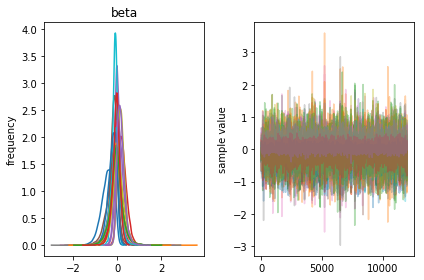

In [20]:
fit.plot('beta')
plt.tight_layout()
plt.show()

### Extracting fit properties

In [ ]:
summary = pystan.stansummary(fit=fit, digits_summary=3)

In [ ]:
summary_arr = np.array(summary.split('\n'))

In [ ]:
new_output = summary_arr[5:-6,]

In [ ]:
count = 0
for i in range(new_output.size):
    row = np.array(new_output[i].split())
    if row.size ==11:
        continue
    else:
        print "new_output[%d] = '%s' " % (i, str(new_output[i]))
        count+=1
print count

In [ ]:
new_output[804] = 'eta01[378]   0.021   0.007  0.538 -0.968 -0.353 -1.45e-4  0.375  1.145   5182    1.0' 
new_output[805] = 'eta01[379]    0.02   0.007  0.539 -0.972 -0.354 -4.73e-4  0.375  1.148   5179    1.0' 
new_output[1509] = 'eta02[283]   0.004   0.002  0.209 -0.395 -0.139 1.94e-4  0.142  0.427   7910    1.0' 
new_output[2059] = 'eta03[33]   -0.051   0.009  0.953  -2.08 -0.599 7.11e-4  0.538  1.767  10563    1.0' 
new_output[2060] = 'eta03[34]   -0.052   0.009  0.954 -2.081 -0.602 -6.12e-4  0.538  1.769  10574    1.0' 
new_output[2061] = 'eta03[35]   -0.053   0.009  0.954 -2.081 -0.603 1.03e-4  0.536  1.771  10586    1.0' 
new_output[2062] = 'eta03[36]   -0.054   0.009  0.954 -2.079 -0.604 7.42e-4  0.534  1.768  10598    1.0' 
new_output[2063] = 'eta03[37]   -0.055   0.009  0.955 -2.082 -0.606 3.26e-4  0.533  1.769  10610    1.0' 
new_output[2068] = 'eta03[42]   -0.047   0.008  0.856 -1.878 -0.541 8.25e-4  0.483  1.594  10432    1.0' 
new_output[2069] = 'eta03[43]   -0.048   0.008  0.856 -1.881 -0.543 -1.14e-4  0.481  1.592  10441    1.0' 
new_output[2070] = 'eta03[44]   -0.048   0.008  0.856 -1.885 -0.542 -4.6e-4   0.48  1.591  10451    1.0' 
new_output[3198] = 'eta04[372]  -0.547   0.008  0.867 -2.335 -1.072  -0.52 7.72e-4  1.142  11998    1.0' 
new_output[3201] = 'eta04[375]  -0.551   0.008  0.869 -2.347 -1.075 -0.523 6.91e-4  1.137  11932    1.0' 
new_output[3202] = 'eta04[376]  -0.552   0.008   0.87 -2.345 -1.077 -0.523 -7.7e-4  1.136  11909    1.0' 
new_output[3203] = 'eta04[377]  -0.553   0.008  0.871  -2.35  -1.08 -0.524 -6.54e-4  1.136  11886    1.0' 
new_output[3204] = 'eta04[378]  -0.554   0.008  0.872 -2.355 -1.082 -0.526 -3.96e-4  1.137  11863    1.0' 

In [ ]:
count = 0
for i in range(new_output.size):
    row = np.array(new_output[i].split())
    if row.size ==11:
        continue
    else:
        print "new_output[%d] = '%s' " % (i, str(new_output[i]))
        count+=1
print count

In [ ]:
header_fit = summary_arr[4].split()
print header_fit

In [ ]:
header_addendum = 'parameter'
header_fit = [header_addendum] + header_fit
print header_fit

In [ ]:
cute_output = list(np.zeros(len(header_fit)))
for i in range(new_output.size):
    if len(new_output[i].split())!=11: # the length of the list must be 11, in which case we connect them directly
        print "there is a problem!"
    else:
        new_output_temp = np.array(new_output[i].split()).reshape(1,11)
        cute_output     = np.vstack((cute_output, new_output_temp))
cute_output = cute_output[1:,:]               # removing the zeroes in the beggining
print cute_output[:,0].shape

# Extracting and saving *ONLY* what really matters for the analysis

In [ ]:
recovered_mass  = un_standardize(stdized_par=plot_x2, mean=mean_mass, std=std_mass)
rp      = np.column_stack((plot_x1, recovered_mass))
rp_cols = np.vstack((rp, rp, rp, rp, rp))       # for 5 whan classes we must stack these 5x
print rp.shape

In [ ]:
parameters = cute_output[:,0].astype(str)
pnew_idxs  = []
for i in range(parameters.size):
    if parameters[i][0:4]=='prob':
        pnew_idxs.append(i)
    else:
        continue
print cute_output[pnew_idxs,:].shape, rp_cols.shape
model_results    = np.column_stack((cute_output[pnew_idxs,:], rp_cols))
model_results_df = pd.DataFrame(model_results)
model_results_df.columns = header_fit + ['Z'] + ['LOG_STELLAR_MASS']
model_results_df.to_csv('./Results/fit_results_sharedprior.csv', sep=',', header=True, index=False)

# Let's save the posteriors

In [ ]:
posteriors_temp = list(fit.extract(u'beta').items()[0])

In [ ]:
posteriors = np.array(posteriors_temp[1])
print posteriors.shape

In [ ]:
print posteriors[0,:,:]
print posteriors[1,:,:]

In [ ]:
matrix_row = posteriors[0,:,0].size  # rows are b0, b1, b2, b3, b4 -- posteriors given the regression
matrix_col = posteriors[0,0,:].size  # cols are w0, w1, w2, w3, w4 -- WHAN classification

In [ ]:
betas_dict = {}
for line in range(matrix_row):
    for col in range(matrix_col):
        betas_dict["beta%d%d" % (line, col)] = posteriors[:, line, col]
betas_df = pd.DataFrame(betas_dict)

In [ ]:
betas_df

In [ ]:
betas_df.to_csv('./Results/betas_sharedprior.csv', sep=',', header=True, index=False)